In [19]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

<div style="font-size:16px;">
-- <span style="color:red;">torch.device</span>代表将torch.Tensor分配到的设备的对象。<br>
-- <span style="color:red;">torch.device</span></span>包含一个设备类型（'cpu'或'cuda'设备类型）和可选的设备的序号。如果设备序号不存在，则为当前设备; 例如，<span style="color:red;">torch.Tensor</span>用设备构建'cuda'的结果等同于'cuda:X',其中X是<span style="color:red;">torch.cuda.current_device()</span>的结果。<br>
-- <span style="color:red;">torch.Tensor</span>的设备可以通过<span style="color:red;">Tensor.device</span>访问属性。<br>
-- 构造<span style="color:red;">torch.device</span>可以通过字符串/字符串和设备编号。<br></div>

In [20]:
device = torch.device('cuda:0')#使用序号为0的GPU

<span style="color:blue; font-size:16px; font-weight:bold;">定义超参数</span>

In [21]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

<span style="color:blue; font-size:16px; font-weight:bold;">下载数据集</span>

In [22]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

<span style="color:blue; font-size:16px; font-weight:bold;">加载数据集</span>

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

<span style="color:blue; font-size:16px; font-weight:bold;">构建cnn网络结构</span>

In [40]:
class Cnn_Model(nn.Module):
    # 定义cnn_model的初始化函数，本函数定义了cnn网络的基本结构
    def __init__(self, num_classes=10):
        # 继承父类的初始化方法，即先运行nn.Module的初始化函数
        super(Cnn_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=5,stride=1,padding=2),#定义第一个卷积层，输入1通道(灰度图)的图片，输出16张特征图，卷积核5x5，padding：每一条边补充0的层数
            nn.BatchNorm2d(16),#标准化
            nn.ReLU(),#激活韩式
            nn.MaxPool2d(kernel_size=2,stride=2)#最大池化
        )
        #计算输出： (28-5+2*2)/1+1 = 28 MaxPool：14
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        #计算输出： (14-5+2*2)/1+1 = 14  MaxPool：7
        # 定义全连接层：线性连接(y = Wx + b)，7*7*32个节点连接到10个节点上   
        self.fc = nn.Linear(7*7*32,num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # 形成一维向量形式，总特征数不变，为全连接层做准备
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        return out

<span style="color:blue; font-size:16px; font-weight:bold;">实例化cnn</span>

In [42]:
model = Cnn_Model(num_classes).to(device)
print(model)

Cnn_Model(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


<span style="color:blue; font-size:16px; font-weight:bold;">打印网络结构</span>

In [64]:
from graphviz import Digraph

def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}
 
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
 
    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'
 
    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [65]:
from torch.autograd import Variable

if __name__ == '__main__':
    net = Cnn_Model()
    x = Variable(torch.randn(1, 1, 28, 28))
    y = net(x)
    g = make_dot(y)
    g.view()
 
    params = list(net.parameters())
    k = 0
    for i in params:
        l = 1
        print("该层的结构：" + str(list(i.size())))
        for j in i.size():
            l *= j
        print("该层参数和：" + str(l))
        k = k + l
    print("总参数数量和：" + str(k))


该层的结构：[16, 1, 5, 5]
该层参数和：400
该层的结构：[16]
该层参数和：16
该层的结构：[16]
该层参数和：16
该层的结构：[16]
该层参数和：16
该层的结构：[32, 16, 5, 5]
该层参数和：12800
该层的结构：[32]
该层参数和：32
该层的结构：[32]
该层参数和：32
该层的结构：[32]
该层参数和：32
该层的结构：[10, 1568]
该层参数和：15680
该层的结构：[10]
该层参数和：10
总参数数量和：29034


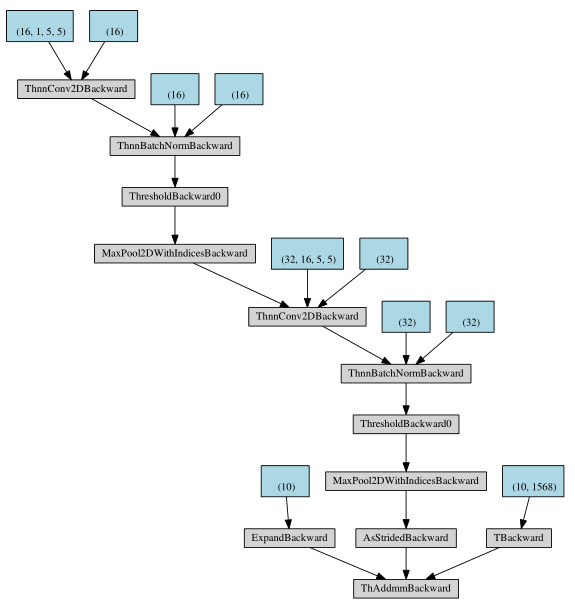

<span style="color:blue; font-size:16px; font-weight:bold;">定义损失函数和优化器</span>

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<span style="color:blue; font-size:16px; font-weight:bold;">开始训练</span>

In [44]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.1609
Epoch [1/5], Step [200/600], Loss: 0.0857
Epoch [1/5], Step [300/600], Loss: 0.0430
Epoch [1/5], Step [400/600], Loss: 0.0176
Epoch [1/5], Step [500/600], Loss: 0.0430
Epoch [1/5], Step [600/600], Loss: 0.0847
Epoch [2/5], Step [100/600], Loss: 0.0116
Epoch [2/5], Step [200/600], Loss: 0.1323
Epoch [2/5], Step [300/600], Loss: 0.0138
Epoch [2/5], Step [400/600], Loss: 0.0619
Epoch [2/5], Step [500/600], Loss: 0.0623
Epoch [2/5], Step [600/600], Loss: 0.0131
Epoch [3/5], Step [100/600], Loss: 0.0604
Epoch [3/5], Step [200/600], Loss: 0.1147
Epoch [3/5], Step [300/600], Loss: 0.0332
Epoch [3/5], Step [400/600], Loss: 0.0666
Epoch [3/5], Step [500/600], Loss: 0.0079
Epoch [3/5], Step [600/600], Loss: 0.0418
Epoch [4/5], Step [100/600], Loss: 0.0728
Epoch [4/5], Step [200/600], Loss: 0.0189
Epoch [4/5], Step [300/600], Loss: 0.0130
Epoch [4/5], Step [400/600], Loss: 0.0310
Epoch [4/5], Step [500/600], Loss: 0.0576
Epoch [4/5], Step [600/600], Loss:

<span style="color:blue; font-size:16px; font-weight:bold;">验证</span>

In [63]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.9 %
